In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.oma_clustering import ModeClusterer
from oma_tracking.scouring.scouring import aggregate_time_series

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from dotenv import load_dotenv
load_dotenv()

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [3]:
simulations_data_path = "../../data/nw2/simulations/" + location + "/"

simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

NameError: name 'location' is not defined

In [ ]:
start  = datetime.datetime(2023,2,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,9,tzinfo=utc)

location = 'nw2d01'
name_location = 'NW2_D01'

mvbc_username = os.getenv('MEETNET_USERNAME') # Replace with your usernam
mvbc_password = os.getenv('MEETNET_PASSWORD') # Replace with your password
creds = Credentials(username=mvbc_username, password=mvbc_password)
b=Base(creds)
b.ping()

c = Catalog(credentials=creds)
df_unfiltered = c.data_points()

weather_station = 'Wandelaar'
weather_station_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )

weather_station_data = weather_station_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [ ]:
dsg = DatasetGetter(start, stop, location)
dsg.get_longterm_data()

In [ ]:
data = dsg.data
mpe_data = data.filter(regex='mpe')
mpe_FA = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().index
        )
mpe_SS = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().index
        )

In [ ]:
mc = ModeClusterer(
    eps = 4,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 2, "damping": 2},
    index_divider = 1000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data = mpe_SS.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc.fit(clustering_data)
clustered_modes = mc.predict(min_cluster_size=200)

fig = plt.figure(figsize = (30,10))
plt.scatter(clustering_data.index, clustering_data['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)
plt.show()
SS1 = clustered_modes[clustered_modes.labels == 0]
SS1 = SS1[~SS1.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)
SS2 = clustered_modes[clustered_modes.labels == 1]
SS2 = SS2[~SS2.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)

In [ ]:
mc = ModeClusterer(
    eps = 5,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 2, "damping": 2},
    index_divider = 1200,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data = mpe_FA.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc.fit(clustering_data)
clustered_modes = mc.predict(min_cluster_size=500)

fig = plt.figure(figsize = (30,10))
plt.scatter(clustering_data.index, clustering_data['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the FA direction')
plt.ylim(0, 1.3)
plt.show()
FA1 = clustered_modes[clustered_modes.labels == 1]
FA1 = FA1[~FA1.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)
FA2 = clustered_modes[clustered_modes.labels == 0]
FA2 = FA2[~FA2.index.duplicated()].reindex(clustering_data[~clustering_data.index.duplicated()].index)

In [ ]:
tracked_frequencies = \
    pd.DataFrame(
        {
            'SS1': SS1.frequency,
            'SS2': SS2.frequency,
            'FA1': FA1.frequency,
            'FA2': FA2.frequency
        },
        index = SS1.index
    )

In [69]:
import mlflow
models = {}
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Production'
    try:
        models[mode] = \
            mlflow.pyfunc.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [70]:
weather_params = \
    [
        'Wave_height', 
        'Sea_water_temperature', 
        'Tide_TAW', 
        'Air_pressure', 
        'Air_temperature', 
        #'Relative_humidity' # TOO MANY NANs
    ]
weather_inputs = weather_station_data[weather_params]

scada_params = \
    [
        'mean_NW2_D01_rpm', 
        'mean_NW2_D01_yaw', 
        'mean_NW2_D01_pitch', 
        'mean_NW2_D01_power', 
        #'std_NW2_D01_towerxacc',  # TOO MANY NANs
        #'std_NW2_D01_toweryacc', # TOO MANY NANs
        #'mean_NW2_D01_towerxacc', # TOO MANY NANs
        #'mean_NW2_D01_toweryacc', # TOO MANY NANs
        'mean_NW2_D01_windspeed',
        'mean_NW2_D01_winddirection',
    ]
scada_inputs = data[scada_params]

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [82]:
from sklearn.metrics import mean_squared_error, r2_score
predictions = pd.DataFrame(index = inputs.dropna().index)
for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
    indices = prediction_params[mode].dropna().index.intersection(predictions[mode].index)
    print(
        mode,
        'R2:', r2_score(predictions[mode].loc[indices], prediction_params[mode].loc[indices]),
        'RRMSE:', np.sqrt(mean_squared_error(predictions[mode].loc[indices], prediction_params[mode].loc[indices])/(predictions[mode].max() - predictions[mode].min()))
    )
residuals = prediction_params - predictions
normalized = residuals + tracked_frequencies.mean()

SS1 R2: -2.5040321867609947 RRMSE: 0.017649160362545054
SS2 R2: 0.3367511646058067 RRMSE: 0.03486064660899387
FA1 R2: 0.09441585000966946 RRMSE: 0.024925709587452927
FA2 R2: 0.43407805727839666 RRMSE: 0.02988503935162195


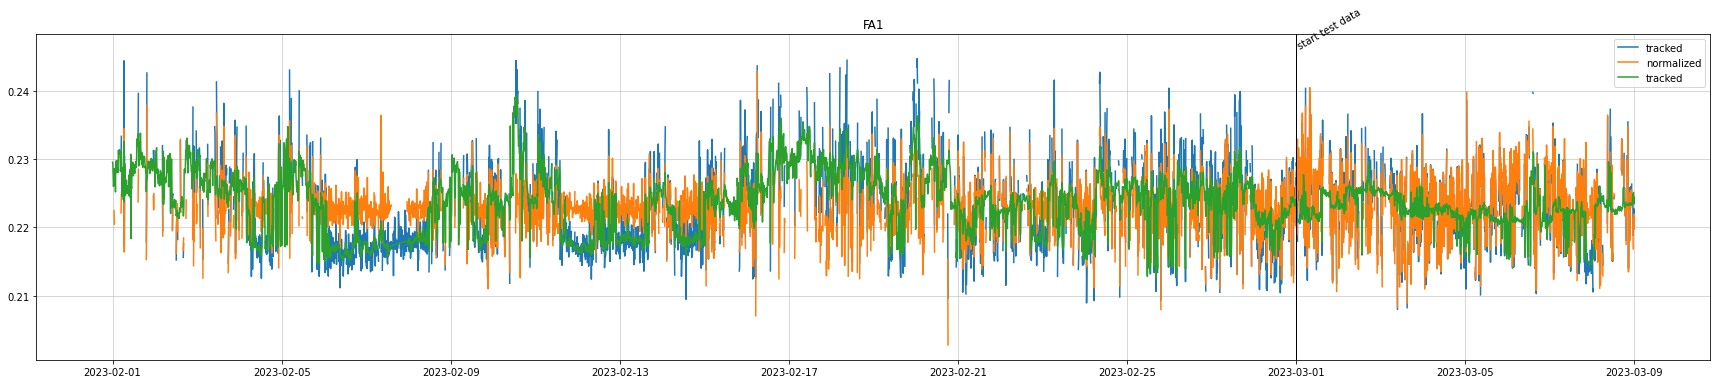

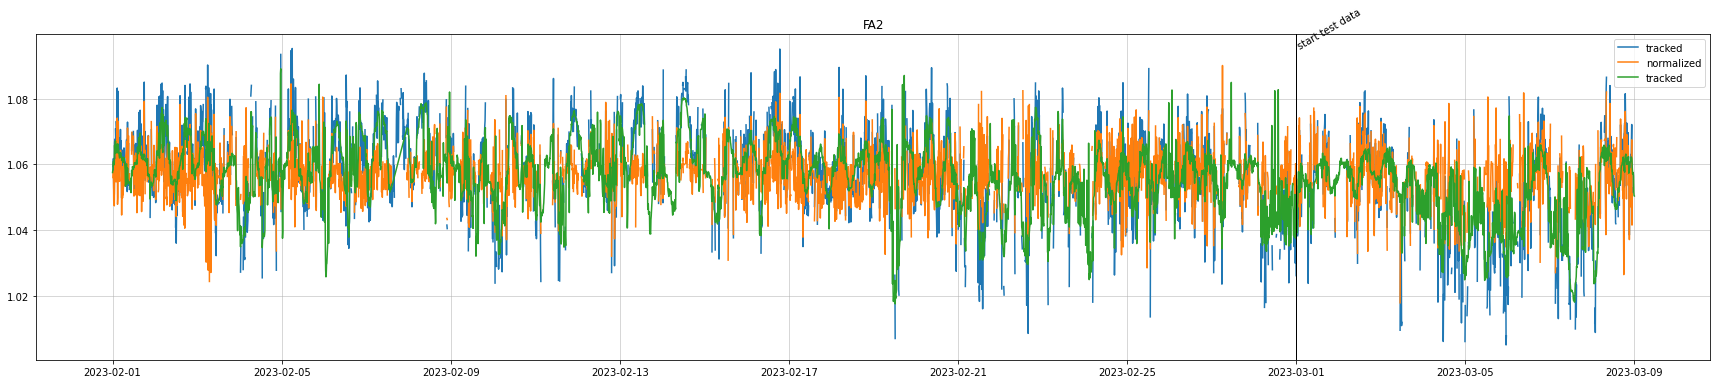

In [91]:
for mode in tracked_frequencies.columns:
    plt.figure(figsize=(30,6))
    plt.grid('--', linewidth=0.5)
    plt.title(mode)
    plt.plot(tracked_frequencies[mode], label = 'tracked')
    plt.plot(normalized[mode], label = 'normalized')
    plt.plot(predictions[mode], label = 'tracked')
    plt.axvline(x =datetime.datetime(2023,3,1), color = 'k', linestyle = '-', linewidth = 1)
    plt.text(datetime.datetime(2023,3,1), tracked_frequencies[mode].max(), 'start test data', rotation=30)
    plt.legend()
    plt.show()


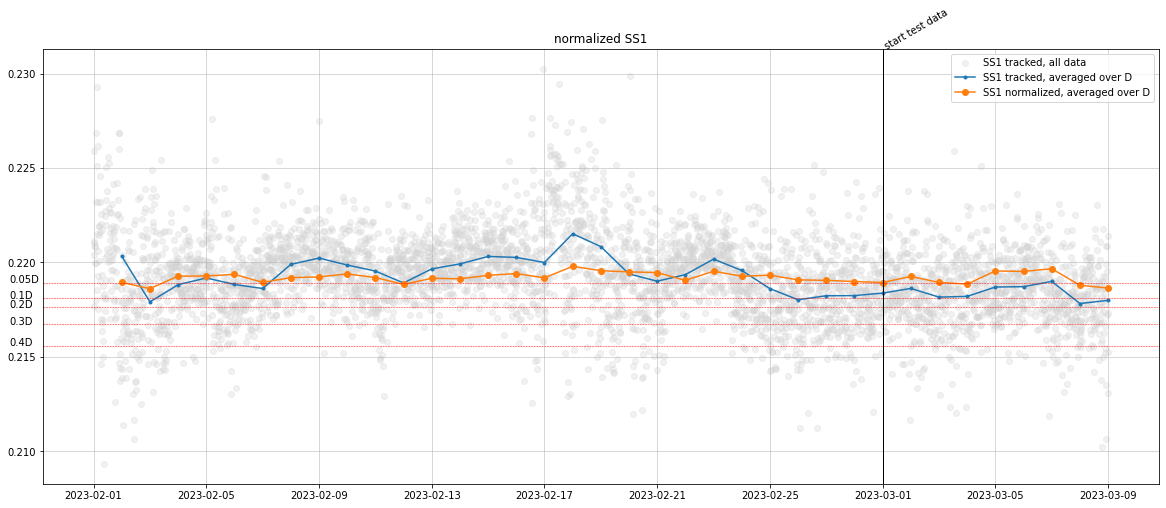

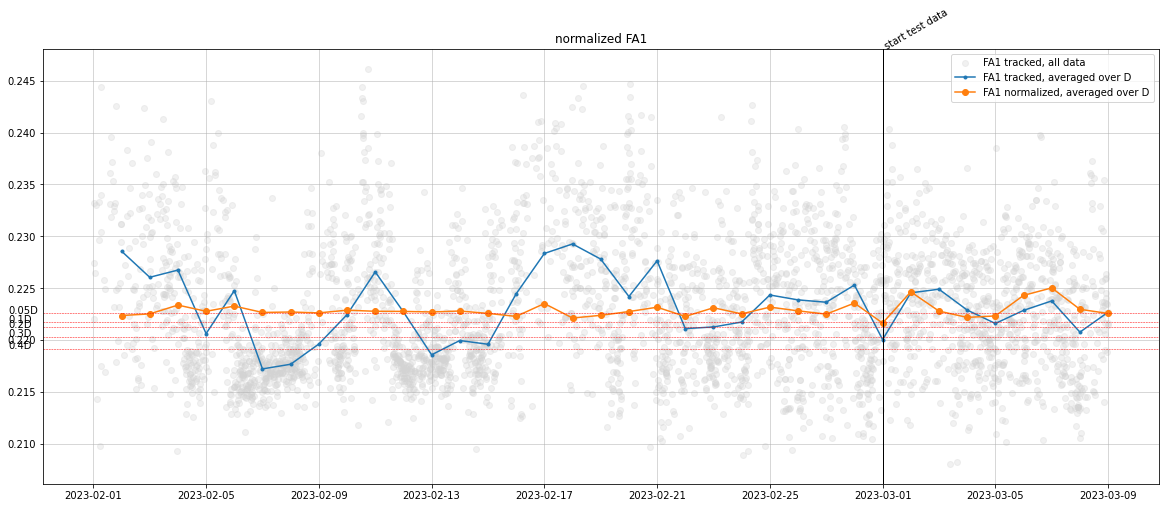

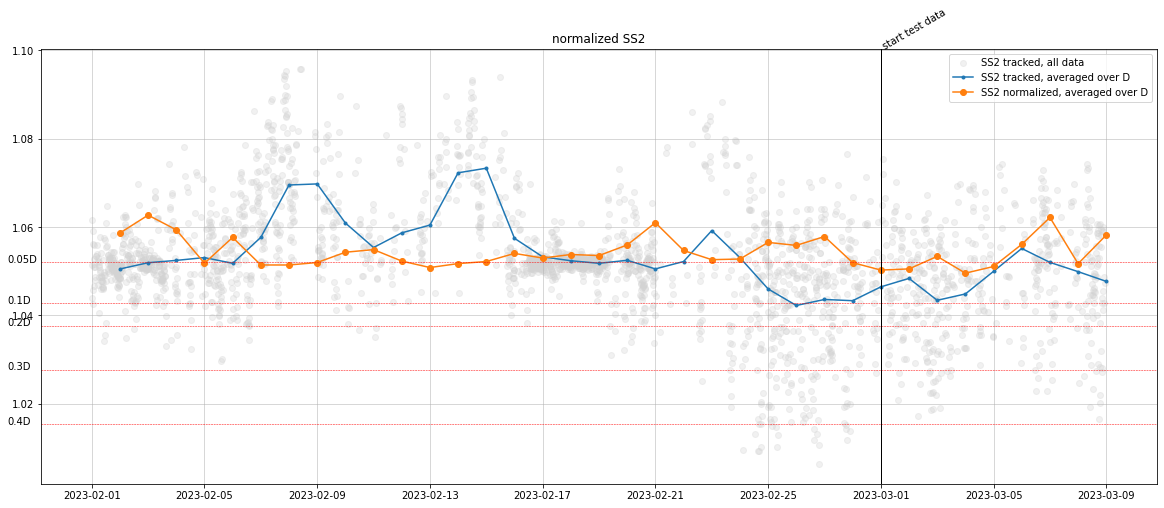

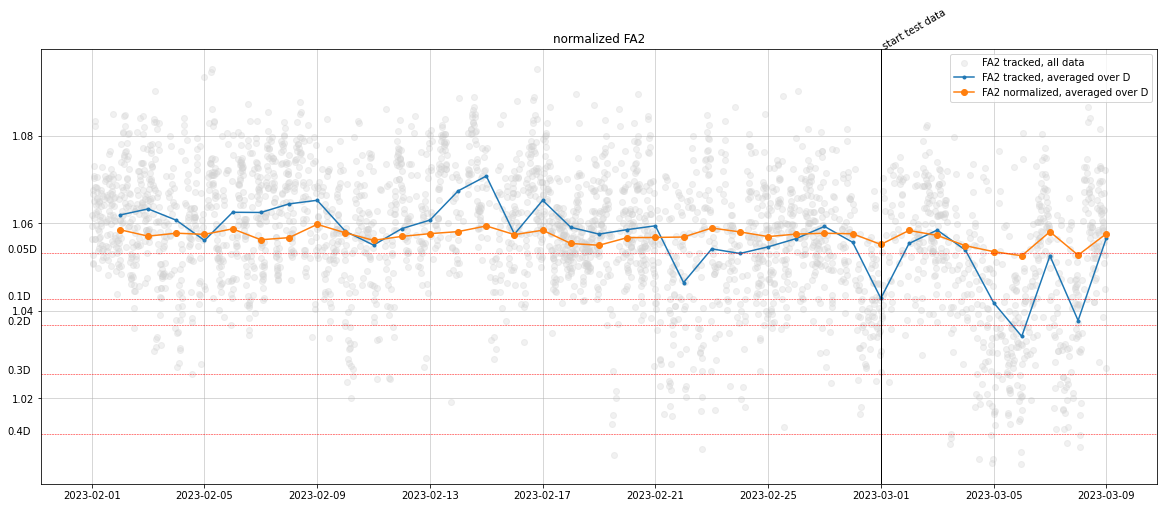

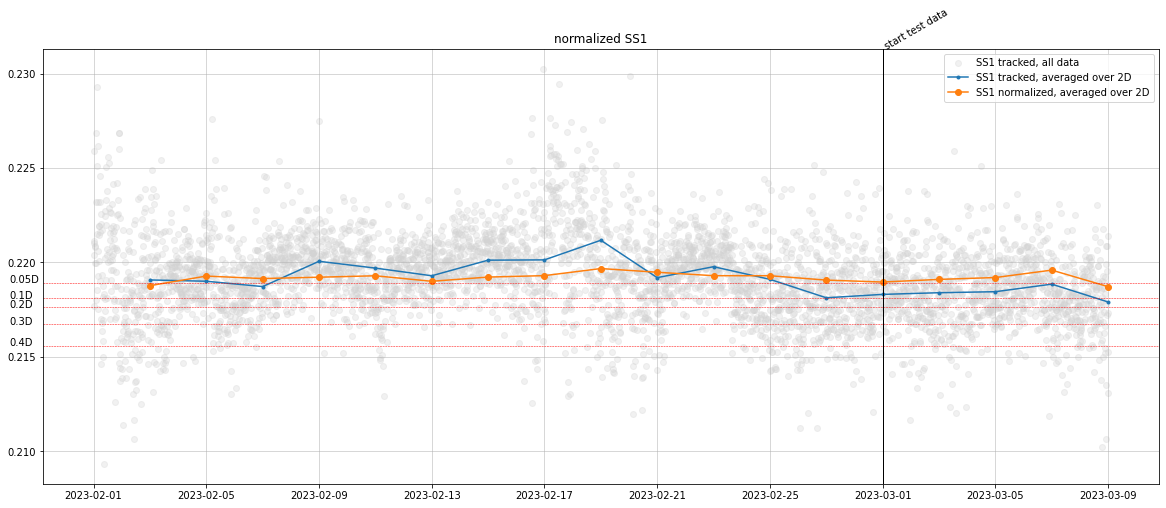

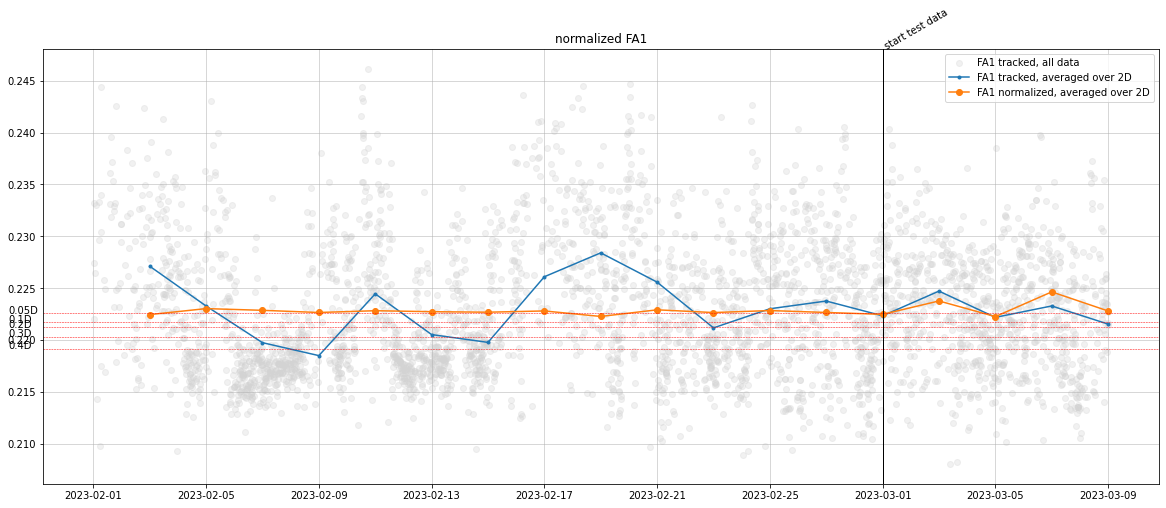

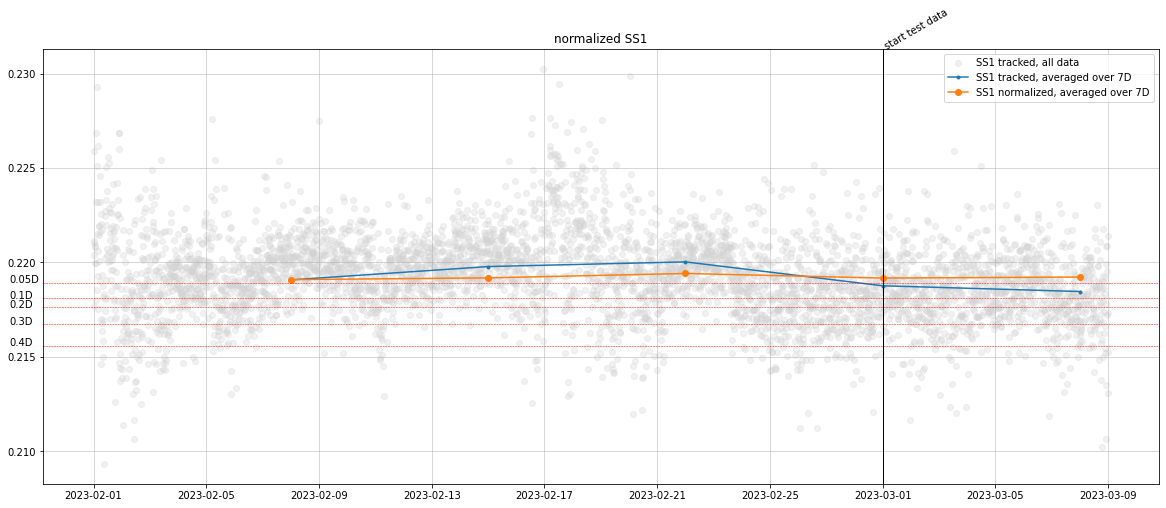

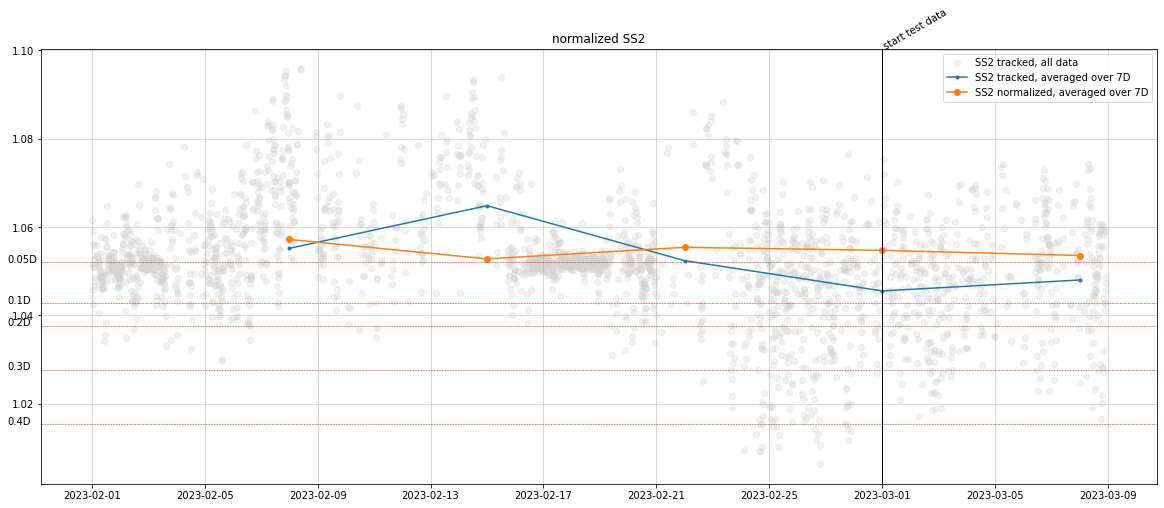

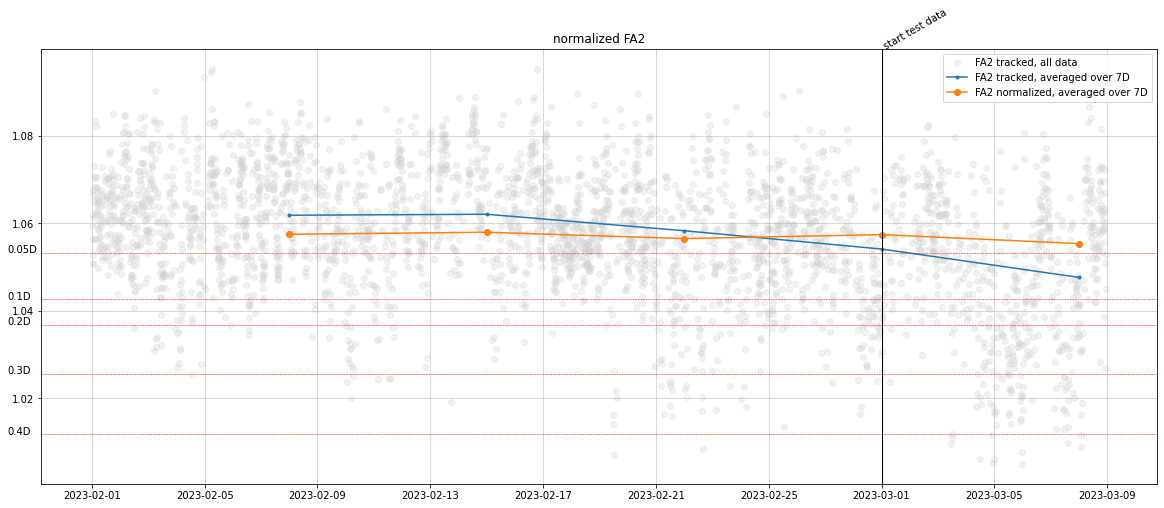

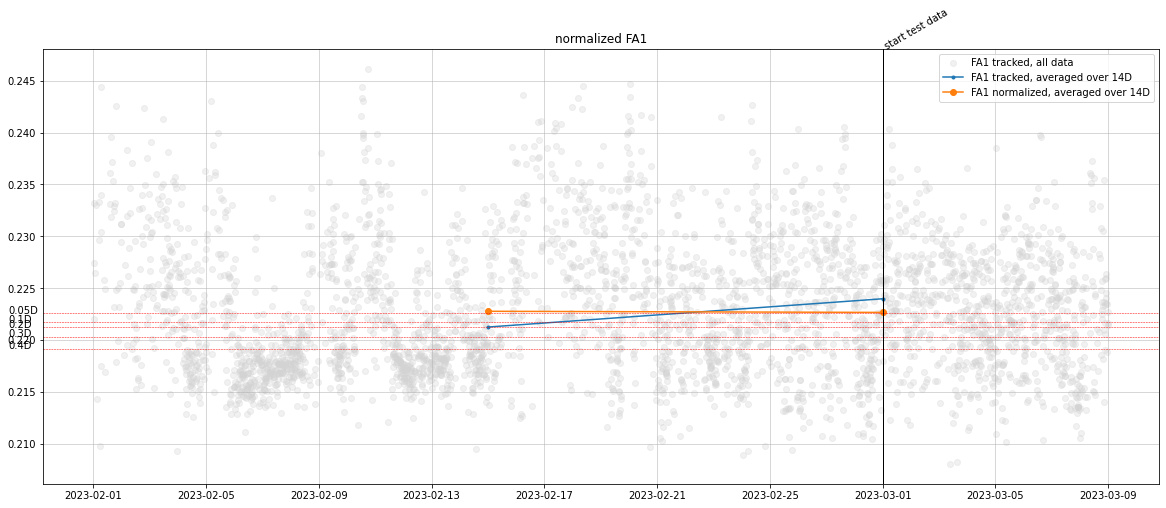

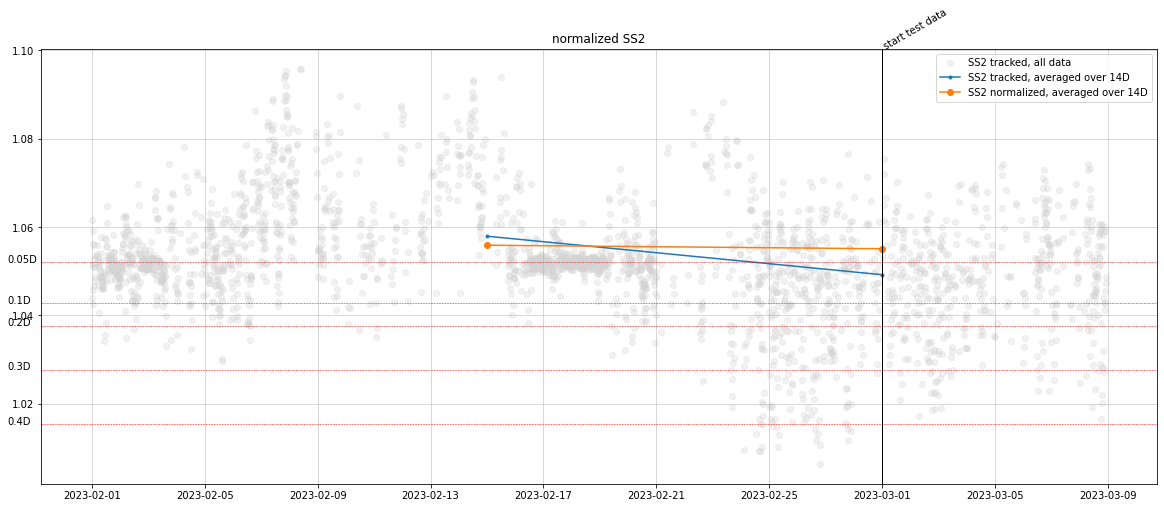

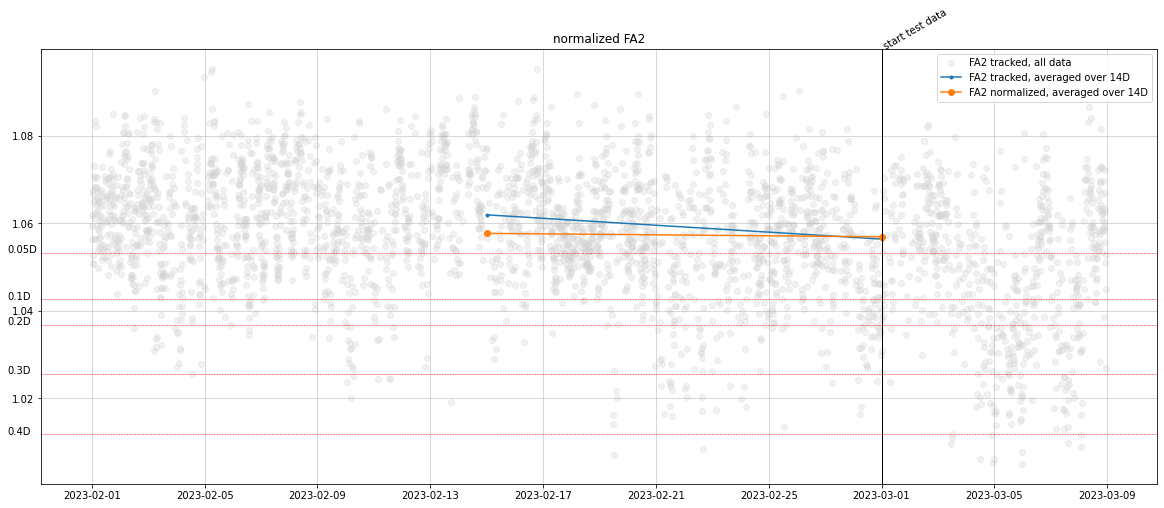

In [95]:
import warnings
warnings.filterwarnings('ignore')
markers = ['.', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
timespans = ['D', '2D', '7D', '14D']
for timespan in timespans:
    for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
        plt.figure(figsize=(20,8))
        plt.grid('--', linewidth=0.5)
        plt.title('normalized ' + mode)
        m = 0
        i = 0
        
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan)
        timely_normalized_frequencies = aggregate_time_series(normalized, timespan)
        plt.scatter(tracked_frequencies[mode].index, tracked_frequencies[mode], color='lightgrey', label = mode + ' tracked, all data', alpha=0.3)
        plt.plot(timely_tracked_frequencies[mode], label = mode + ' tracked, averaged over ' + timespan, marker = markers[m])
        m += 1
        plt.plot(timely_normalized_frequencies[mode], label = mode + ' normalized, averaged over ' + timespan, marker = markers[m])

            
        for value in simulation_shifts['parked_scour'][mode].values[:5]:
            plt.axhline(normalized[mode].mean() - normalized[mode].mean()*value/100, color='red', linestyle='--', linewidth=0.5)
            plt.text(normalized[mode].index[0] - datetime.timedelta(days=3), normalized[mode].mean() - normalized[mode].mean()*value/100, simulation_shifts['parked_scour']['Unnamed: 0'].values[i])
            i += 1
        plt.axvline(x =datetime.datetime(2023,3,1), color = 'k', linestyle = '-', linewidth = 1)
        y_lim = plt.ylim()
        plt.text(datetime.datetime(2023,3,1), y_lim[1], 'start test data', rotation=30)
        plt.legend()
        plt.show()